In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress

from datetime import datetime
from dateutil.parser import parse

import math
import os
import copy
import pickle

import drugLookup

from itertools import groupby
from operator import itemgetter
from hmmlearn import hmm

In [2]:
# Read in data (from pickle file)
file = open('train_set_filtered','rb')
train_set_filtered = pickle.load(file)

file = open('test_set_filtered','rb')
test_set_filtered = pickle.load(file)

## Get subset of data for HMM

In [3]:
# Number of train/test sequences to use
n_train = 245
n_test = 82
len_seq = 100 # length of each sequence

# Get subset of train/test set
v_train = np.array(train_set_filtered['vendor_name'][-n_train*len_seq:])
d_train = np.array(train_set_filtered['drug_prediction'][-n_train*len_seq:])
v_test = np.array(test_set_filtered['vendor_name'][:n_test*len_seq])
d_test = np.array(test_set_filtered['drug_prediction'][:n_test*len_seq])

## Emission Probability Table

In [4]:
# Function gets tally of drugs sold for given vendor
def getDrugsForVendor(vendor_name):
#     Args: Name of a vendor (string)
#     Returns: series, representing proportion of total for each drug
    vendor_subset = train_set_filtered[train_set_filtered['vendor_name'] == vendor_name]
    vendor_drug_tally = vendor_subset['drug_prediction'].groupby(vendor_subset['drug_prediction']).count()
    return(vendor_drug_tally/np.sum(vendor_drug_tally))

In [5]:
# Get list of vendors in the data frame
_ , vendor_list = pd.factorize(v_train, sort = True)

# Factorize drug_predictions
_ , drug_list = pd.factorize(d_train, sort = True)

In [6]:
#Create emission probability dataframe
emission_prob_table = pd.DataFrame(columns = drug_list)

#Insert vendor name column
emission_prob_table.insert(0, "Vendor Name", vendor_list)

# Apply function to dataframe
emission_prob_table.iloc[:,1:] = emission_prob_table['Vendor Name'].apply(getDrugsForVendor)

In [7]:
# Sort by Vendor name and fill NA values with 0
emission_prob_table = emission_prob_table.fillna(0)

In [8]:
# shift the emission_prob_table (dataframe) to array format
ems_prob = np.array(emission_prob_table)[:,1:]
ems_prob = np.array(list(ems_prob[:, :]), dtype=np.float) # convert to float
ems_prob.shape

(190, 15)

In [9]:
# Functions to encode and decode the sequences
def encode(seq, encoder):
    code = np.array([encoder[element] for element in seq])
    return code

def decode(code, codebook):
    seq = [codebook[element] for element in code]
    return seq

# Encode drugs for training
drug_categories = list(emission_prob_table)[1:]
drug_keys = range(0, len(drug_categories))
drug_encoder = dict(zip(drug_categories, drug_keys))
drug_codebook = dict(zip(drug_keys, drug_categories))
d_train_encoded = encode(d_train, drug_encoder)
d_test_encoded = encode(d_test, drug_encoder)

# Make vendor codebook (for evaluation)
vendor_list = list(emission_prob_table['Vendor Name'])
vendor_keys = range(0, len(vendor_list))
vendor_codebook = dict(zip(vendor_keys, vendor_list))

In [10]:
# Reshape data for model
v_train = v_train.reshape((n_train,len_seq))
d_train_encoded = d_train_encoded.reshape((n_train,len_seq))
v_test = v_test.reshape((n_test,len_seq))
d_test_encoded = d_test_encoded.reshape((n_test,len_seq))

In [11]:
# 使用Baum-Welch算法来估计参数，然后使用Viterbi算法来预测隐状态数列。

def hmm_BaumWelch(data, n_states, n_iter=100, n_train=10):
    """
    @ parameters:
        data (matrix): The encoded observed sequence of hidden state
        n_states (int): The length of sequence for hidden state. 
        n_iter (int): The iteration of hmm.MultinomialHMM.
        n_train (int): The training times.
    @ return:
        start_prob (list): Start probability with size = 1 x n_states.
        trans_prob (matrix): Transition probability matrix with size = n_states x n_states.
    """
    # Check the input format
    if len(data) < 2 or len(data[0]) < 1:
        return print("The input dataset should be 2D.")
    if n_states < 1 or n_iter < 1 or n_train < 1:
        return print("Please input positive integer number for parameters.")
    # Initialize the parameters
    score0 = float("-inf")
    start_prob = 0
    trans_prob = 0
    # Build the model
    model = hmm.MultinomialHMM(n_components=n_states, n_iter=int(n_iter))
    # Run "n_train" times to train the model and select the best parameters.
    for _ in range(0, int(n_train)):
        model.fit(data) # 模型的拟合比较耗时
        print("Model fitted in round {0}!".format(_))
        # hmm2.0里的score函数接受2D作为输入格式
        scores = sum([model.score([data[i]]) for i in range(len(data))]) #score越大越好（若带负号，则绝对值越小越好）
        print(scores)
        if scores > score0:
            start_prob = model.startprob_
            trans_prob = model.transmat_  
            # 发射概率已知，这里无须估计。
        score0 = max(score0, scores)
    return start_prob, trans_prob

# https://stackoverflow.com/questions/34379911/how-to-run-hidden-markov-models-in-python-with-hmmlearn
def hmm_Viterbi(obs_seq, start_prob, trans_prob, ems_prob, n_states, n_train=10, verbose=True):
    """
    @ parameters:
        obs_seq (list): An encoded observed sequence of hidden state.
        start_prob (list): Start probability with size = 1 x n_states.
        trans_prob (matrix): Transition probability matrix with size = n_states x n_states.
        ems_prob (matrix): Emission probability with size = len(vlist) x len(dlist).
        n_states (int): The length of sequence for hidden state. 
        n_train (int): The training times.
        verbose (boolean): Print out the comment if True.
    @ return:
        vendor0 (list): Predicted sequence of hidden state.
    """
    # Check the input format
    if len(obs_seq) < 1:
        return print("The length of observed sequence should be larger than 1.")
    if n_states < 1 or n_train < 1:
        return print("Please input positive integer number for parameters.")
    if n_states != (len(trans_prob) or len(trans_prob[0])):
        return print("The size of trans_prob is not correct.")
    if len(start_prob) != len(trans_prob):
        return print("The size of start_prob and trans_prob doesn't match.")    
    # Build the model and initialize the parameters
    model = hmm.MultinomialHMM(n_components=n_states)
    model.startprob_= start_prob
    model.transmat_ = trans_prob
    model.emissionprob_ = ems_prob
    logprob0 = float("-inf")
    vendor0 = 0
    # Run "n_train" times to train the model and select the best parameters.
    for _ in range(0, int(n_train)):
        # decode: Given parameters and observed sequence, employ Viterbi algorithm to predict the hidden state.
        logprob, vendors = model.decode(list(obs_seq), algorithm="viterbi") # obs_seq must be list rather than array.
        if logprob > logprob0: # update "vendors" when logprob is larger than previous one.
            vendor0 = vendors
        logprob0 = max(logprob0, logprob)
    if verbose:
        print("The best logprob is: ", logprob0) #该参数反映模型拟合的好坏,数值越大越好。
    return vendor0

def evaluation(hs_seq_pred, hs_seq_gt, verbose=True):
    # 评价预测结果：Compute the accuracy
    if verbose:
        print("The set of predicted hidden state sequence: \n", set(hs_seq_pred))
        print("-"*90)
        print("The set of groundtruth hidden state sequence: \n", set(hs_seq_gt))
    cnt = 0
    for i in range(len(hs_seq_pred)):
        if hs_seq_pred[i] == hs_seq_gt[i]:
            cnt += 1
    return round(cnt/len(hs_seq_pred), 4)


In [12]:
import time

# Initialize the parameters
vlist = np.array(emission_prob_table)[:,0]
dlist = list(set(train_set_filtered['drug_prediction']))
states = vlist # totally 190 vendors
observations = dlist # totally 15 drugs
# encode the observed dataset
data_dseq_ec = d_train_encoded

start_time = time.time()
# Employ Baum-Welch algorithm to estimate the parameters
start_prob, trans_prob = hmm_BaumWelch(data_dseq_ec, len(states), n_iter=10, n_train=10)
end_time = time.time()

# Save the parameters to txt file
#output_path1 = 'vendor_frq_start_prob.txt'
#output_path2 = 'vendor_frq_trans_prob.txt'
#saveOutput(output_path1, start_prob)
#saveOutput(output_path2, trans_prob)


Model fitted in round 0!
-60406.363008364635
Model fitted in round 1!
-60420.2895571377
Model fitted in round 2!
-60378.86407104076
Model fitted in round 3!
-60169.99838747538
Model fitted in round 4!
-60217.60651607769
Model fitted in round 5!
-60180.28137327409
Model fitted in round 6!
-60349.74755584432
Model fitted in round 7!
-60159.540954846496
Model fitted in round 8!
-60352.07782137212
Model fitted in round 9!
-60510.6371412835


In [18]:
import pickle
file = open('start_prob_2','wb')
pickle.dump(start_prob, file)
file.close()

file = open('trans_prob_2','wb')
pickle.dump(trans_prob, file)
file.close()

In [19]:
# 测试：预测和评价
def testing(test_obs, test_hs, idx, drug_codebook, vendor_codebook, verbose=True):
    obs_seq = test_obs[idx]
    obs_seq_ec = obs_seq.reshape(-1,1)

    # Employ Viterbi algorithm to estimate the parameters
    vendors = hmm_Viterbi(obs_seq_ec, start_prob, trans_prob, ems_prob, len(states), n_train=5, verbose = verbose)
    
    # Evaluation（对预测结果进行评价-accuracy）
    hs_seq_pred = [states[vendor_idx] for vendor_idx in vendors]
    hs_seq_gt = test_hs[idx]
    acc = evaluation(hs_seq_pred, hs_seq_gt, verbose=False)
    
    actual_drugs = decode(obs_seq, drug_codebook)
    actual_vendors = hs_seq_gt
    predicted_vendors = decode(vendors, vendor_codebook)
    
    df = pd.DataFrame({'drug':actual_drugs, 'actual_vendor': actual_vendors, 'predicted_vendor':predicted_vendors})
    df['correct'] = df['actual_vendor'] == df['predicted_vendor']

    return(df)

# Scenario3: select all samples from the testing set.
results = pd.concat([testing(d_test_encoded, v_test, idx, drug_codebook, vendor_codebook)\
                for idx in range(len(d_test_encoded))])

/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -419.70956328694456
The best logprob is:  -416.7510688945125
The best logprob is:  -421.77330429269546
The best logprob is:  -408.6333115686674


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -401.3513538341691
The best logprob is:  -409.13843710436913
The best logprob is:  -397.29185271881704
The best logprob is:  -406.3239600135294
The best logprob is:  -420.9067169315201


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -404.56029878229833
The best logprob is:  -408.63946107906554
The best logprob is:  -409.47062508643995
The best logprob is:  -402.94009216507163


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -405.58983464910466
The best logprob is:  -419.58985790959775
The best logprob is:  -420.04849085360746
The best logprob is:  -408.18311748354296


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -421.82092794320124
The best logprob is:  -413.03254531585264


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -399.78978943584286
The best logprob is:  -391.71932656417545


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -413.9706288268113
The best logprob is:  -419.2506090389662
The best logprob is:  -401.27056091965056


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -417.78810815708687
The best logprob is:  -404.2704420774268
The best logprob is:  -410.65987298803054


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -424.6913831015199
The best logprob is:  -398.94691482757304
The best logprob is:  -422.13924698859756


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -402.7036289358478
The best logprob is:  -433.089658567269
The best logprob is:  -396.3563402422333
The best logprob is:  -405.1868376398096


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -420.0577312667881
The best logprob is:  -409.55557995758346
The best logprob is:  -402.06459602642497


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -404.0861794903786
The best logprob is:  -408.4249699493986
The best logprob is:  -406.52678522328665
The best logprob is:  -410.5720518242312


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -405.0641134199711
The best logprob is:  -397.5540565741205
The best logprob is:  -406.68390285198853


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -406.8774822819654
The best logprob is:  -404.2466218739209
The best logprob is:  -409.2845047840348


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -384.20605949465175
The best logprob is:  -416.466772436865
The best logprob is:  -409.1780532174321


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -407.02048898150053
The best logprob is:  -410.66466242173675
The best logprob is:  -425.9739693991943
The best logprob is:  -399.3215964784806


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -405.73955913468075
The best logprob is:  -414.81131773535606
The best logprob is:  -403.1873199486866


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -410.62794527342686
The best logprob is:  -413.01897345194936
The best logprob is:  -425.42189430644464
The best logprob is:  -408.79139157347055


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -393.90692438853927
The best logprob is:  -396.9168675335597
The best logprob is:  -414.44692528980937
The best logprob is:  -403.742907851782
The best logprob is:  -420.1817673298439


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -411.8362207082901
The best logprob is:  -413.313165283553
The best logprob is:  -414.60880231656955
The best logprob is:  -416.0670372281805


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -407.4890959522168
The best logprob is:  -422.3557346458256
The best logprob is:  -411.55049188336045


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -413.7526170406608
The best logprob is:  -405.51206541348404
The best logprob is:  -401.6528145623786
The best logprob is:  -405.9917791258693


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

The best logprob is:  -409.9319464335944
The best logprob is:  -398.5350037969809
The best logprob is:  -428.3655829672212
The best logprob is:  -414.0756110883469
The best logprob is:  -402.3730777073546


/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, n

In [20]:
results[results.drug == 'cocaine']
results.drug.value_counts()
results.actual_vendor.value_counts()
results.predicted_vendor.value_counts()

print(len(results.actual_vendor.value_counts()))
print(len(results.predicted_vendor.value_counts()))

n_correct = results.correct.value_counts()[True]
n_wrong = results.correct.value_counts()[False]
accuracy = n_correct/(n_correct+n_wrong)
print('Accuracy:',round(100*accuracy,2),'%')

190
114
Accuracy: 7.57 %


In [21]:
results.shape

(8200, 4)

In [22]:
print(end_time-start_time)

14413.013780117035


In [27]:
e_time = end_time-start_time
e_time / 60 / 60

4.003614938921398

In [16]:
results.actual_vendor.value_counts()/np.sum(results.actual_vendor.value_counts())

MoonBanana              0.018293
DDUK-NDD                0.017195
Perfect.Shrooms         0.016585
sthompson               0.016098
Kman3000                0.015244
ETHER_MART              0.014878
DCdutchconnectionUK     0.014756
Only_dmt_from_tj        0.013659
Gladyman                0.013537
karmaking               0.013049
TheLollipopGuild        0.012683
Smokey1884              0.012317
ricksimpsonstyle        0.012073
Qualitywhitee           0.011951
KungMarkatta            0.011829
mushroomswaterfowl17    0.010976
BlackSheepSquadron      0.010854
ukbk                    0.010244
Hyperamigo              0.010244
bangalow                0.010122
tinyrock                0.010122
WhiteCastle             0.010000
dankcity                0.009756
xanastan                0.009756
pabst_paul              0.009634
VEVO                    0.009390
NELIZ                   0.009268
Aphelion                0.009268
SNIFFKING               0.008902
DerSandmann             0.008780
          

In [17]:
results.predicted_vendor.value_counts()/np.sum(results.predicted_vendor.value_counts())

TREES                   0.083659
pastrydam               0.069268
DDUK-NDD                0.063537
TheCzechMeth            0.054146
NELIZ                   0.044878
Shiny.Flakes            0.043659
frosties2014            0.043659
420HighStreet           0.043537
PHARMALABS              0.035610
highadventure           0.035610
A1CRACK                 0.028780
GreenFingers            0.025732
OneStop                 0.025122
Only_dmt_from_tj        0.024268
MercenaryGB             0.023537
Dr_Seuss_FR             0.021585
GRUENEWALDSCAVE         0.020244
speedzone               0.019024
GreenSupreme            0.017683
LiLXanax                0.017073
zouaves                 0.016220
MoonBanana              0.012927
Subs_Unlimited          0.010854
philppplein             0.010610
VEVO                    0.010488
ukbk                    0.010244
ICE-CUBE                0.010122
AlanCuring420_UK        0.008537
value.lucid             0.008415
BlackSheepSquadron      0.008171
          

In [28]:
trans_prob

array([[0.01900803, 0.00390414, 0.00506536, ..., 0.00447504, 0.00591451,
        0.00498868],
       [0.00320907, 0.02337021, 0.00563973, ..., 0.00292974, 0.00482234,
        0.00452575],
       [0.00500716, 0.00706396, 0.00683236, ..., 0.00388328, 0.00588629,
        0.00506027],
       ...,
       [0.00490707, 0.00338391, 0.00409383, ..., 0.00916537, 0.00449476,
        0.00863555],
       [0.00555137, 0.00604254, 0.00555544, ..., 0.00368017, 0.01179349,
        0.00619251],
       [0.00496584, 0.0049153 , 0.00486679, ..., 0.00761223, 0.00643359,
        0.01383761]])

In [6]:
import seaborn

In [2]:
import pickle
file = open('jun26_trans_probs','rb')
trans_probs = pickle.load(file)

In [3]:
trans_probs.shape

(190, 190)

In [39]:
emission_prob_table.head()

,Vendor Name,amphetamine,benzodiazepines,buprenorphine,cocaine,dmt,ecstasy,hashish,heroin,ketamine,lsd,marijuana,methamphetamine,others,oxycodone,psilocybin
0,24-7SmokeShop,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,420HighStreet,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,9incecloud,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A1CRACK,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alagbada726,0.419643,0.580357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


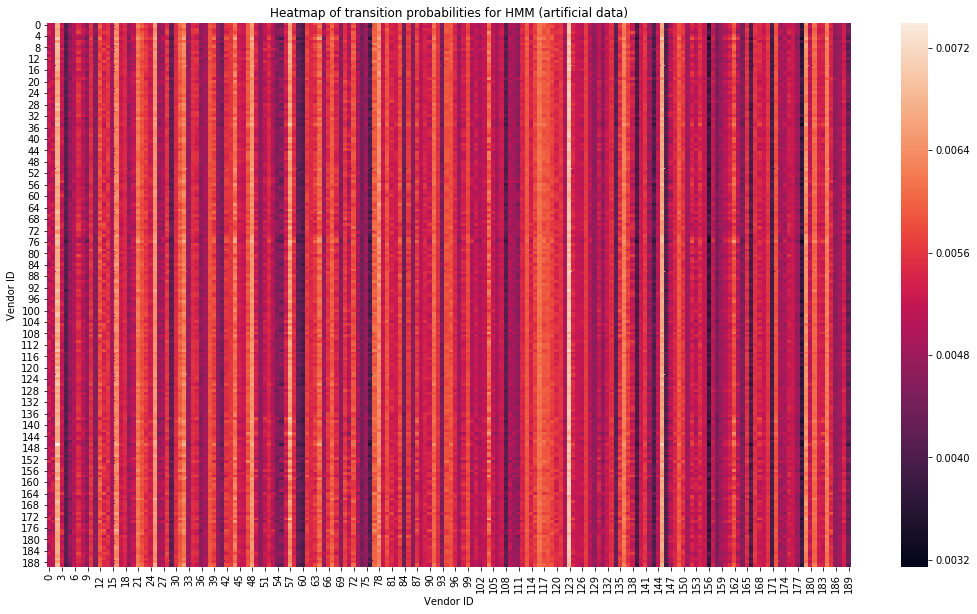

In [10]:
plt.figure(figsize = (18,10))
seaborn.heatmap(trans_probs)
plt.title('Heatmap of transition probabilities for HMM (artificial data)')
plt.xlabel('Vendor ID')
plt.ylabel('Vendor ID')
plt.show()